In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML100k'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[dftrain,dfvalid,results_concat]=pickle.load(open(f'{DATAPATH}/df_side_cold_runother.pkl','rb'))

In [4]:
df=pd.concat([dftrain,dfvalid[dftrain.columns]],axis=0)

In [5]:
user_to_idx={j:i+1 for i, j in enumerate(df['userId'].unique())}
item_to_idx={j:i+1 for i,j in enumerate(df['itemId'].unique())}
idx_to_user={i+1:j for i, j in enumerate(df['userId'].unique())}
idx_to_item={i+1:j for i,j in enumerate(df['itemId'].unique())}

In [6]:
dftrain['user_idx']=[user_to_idx[i] for i in dftrain['userId']]
dftrain['item_idx']=[item_to_idx[i] for i in dftrain['itemId']]

In [7]:
dfvalid['user_idx']=[user_to_idx[i] for i in dfvalid['userId']]
dfvalid['item_idx']=[item_to_idx[i] for i in dfvalid['itemId']]

In [8]:
pickle.dump([df, dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx],open(f'{DATAPATH}/reads.pkl','wb'))

### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(dftrain[['user_idx','item_idx']],dftrain['rating'])
dsvalid=cfdata(dfvalid[['user_idx','item_idx']],dfvalid['rating'])

In [11]:
dftrain.shape

(90543, 391)

In [60]:
bs=64

In [61]:
dltrain=DataLoader(dstrain,bs,True)

In [62]:
dlvalid=DataLoader(dsvalid,bs,False)

In [63]:
len(user_to_idx),len(item_to_idx)

(610, 9724)

## Model Architecture

In [45]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05
hidden=[75,15]
dropouts=[0.2,0.2]

In [46]:
n_users

610

In [47]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [48]:
n_users

610

In [49]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [50]:
cfobj

cf(
  (emb_user): Embedding(611, 25)
  (emb_item): Embedding(9725, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(611, 1)
  (ib): Embedding(9725, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [51]:
for Xb, Yb in dltrain:
    break

In [52]:
Xb.shape, Yb.shape

(torch.Size([256, 2]), torch.Size([256, 1]))

In [53]:
cfobj.forward(Xb,Yb)

(tensor([[4.7234],
         [4.1031],
         [0.5102],
         [0.7129],
         [3.2753],
         [3.0833],
         [2.8888],
         [4.5506],
         [3.7309],
         [3.8481],
         [0.6190],
         [2.2768],
         [1.2331],
         [2.5048],
         [3.4566],
         [2.9600],
         [4.6897],
         [3.1376],
         [1.4150],
         [3.4412],
         [3.9962],
         [1.5041],
         [2.0266],
         [4.8518],
         [4.7654],
         [2.9168],
         [2.7039],
         [1.0559],
         [2.6096],
         [4.6234],
         [1.0057],
         [2.9834],
         [2.2637],
         [3.7657],
         [1.1579],
         [4.0754],
         [2.3499],
         [4.5901],
         [3.2683],
         [3.9577],
         [2.8132],
         [1.3078],
         [4.2900],
         [0.9950],
         [4.9552],
         [4.8641],
         [2.7675],
         [4.9073],
         [2.7147],
         [4.2697],
         [1.3207],
         [2.7327],
         [4.

## Learner

In [54]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [55]:
if 1==1:
    del cfobj
    torch.cuda.empty_cache()

In [56]:
device='cuda:0'

In [57]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [58]:
cfobj=cfobj.to(device)

In [59]:
cfobj

cf(
  (emb_user): Embedding(611, 25)
  (emb_item): Embedding(9725, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(611, 1)
  (ib): Embedding(9725, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [33]:
len(dltrain)

354

In [34]:
wd=1e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,5000,0.25,cycle_mult=0)

In [35]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

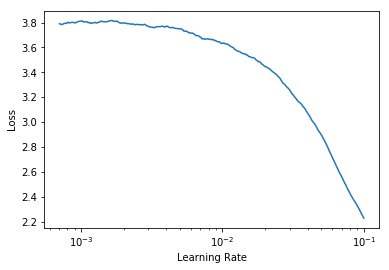

In [36]:
learner.plot_lrs(100)

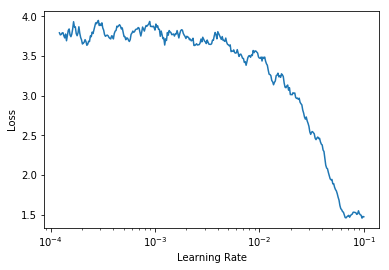

In [37]:
learner.plot_lrs(10)

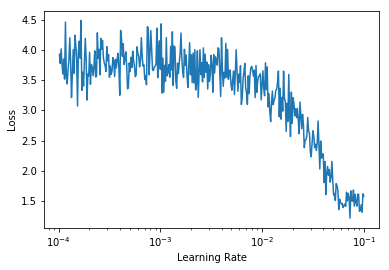

In [38]:
learner.plot_lrs(1)

In [64]:
del cfobj
torch.cuda.empty_cache()

In [65]:
wd=1e-4

In [66]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [67]:
device

'cuda:0'

In [68]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=8e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=2,start_lr=9e-3,end_lr=5e-4,wd_mult=1.2)

In [69]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.008 Weight Decay 0.0001 Train Loss:1.5579728952987455                 Valid Loss:0.9030373039082711 Train RMSE:1.2089301511553576 Valid RMSE:0.9343690971637505 Train MSE:1.5579728952987455 Valid MSE:0.9030373039082711                 Train MAE:0.9512441474220357 Valid MAE:0.7365609466659356
Epoch:1 Learning rate 0.002 Weight Decay 0.00012 Train Loss:0.6548120081845947                 Valid Loss:0.8259540790726679 Train RMSE:0.804464735856463 Valid RMSE:0.8921638931343163 Train MSE:0.6548120081845947 Valid MSE:0.8259540790726679                 Train MAE:0.6201713287366996 Valid MAE:0.7059338235336802
Epoch:2 Learning rate 0.0005 Weight Decay 0.000144 Train Loss:0.5504500367616175                 Valid Loss:0.8182121828105879 Train RMSE:0.7373732775202422 Valid RMSE:0.8880566553803473 Train MSE:0.5504500367616175 Valid MSE:0.8182121828105879                 Train MAE:0.5707515936015772 Valid MAE:0.7038882535807094
Epoch:3 Learning rate 0.008 Weight Decay 0.0001 T

In [70]:
learner.generate_scores=True

In [71]:
learner.run_epoch(dlvalid,False)

(0.7800385876101736, 0.6918467457250038, 0.8679083520485602)

In [72]:
np.concatenate(learner.scores)

array([4.734829 , 4.5826454, 4.6863804, ..., 3.1607249, 3.2630296,
       3.3152425], dtype=float32)

In [73]:
dfvalid['pred_cf']=np.concatenate(learner.scores)

In [74]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_cf']))

0.8824326926455209

In [75]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [76]:
result_cf=pd.concat([score_by_group(dfvalid,'pred_cf','cold_start_group','cf'),score_by_group(dfvalid,'pred_cf','cold_start_bucket','cf'),\
score_by_group(dfvalid,'pred_cf','flag_train','cf')],axis=0)
result_cf

,method,mse,rmse,mae,r2_score,Cold Start Group
0,cf,0.761769,0.872794,0.681150,0.309807,No-cold-start
1,cf,0.833477,0.912950,0.740031,0.354490,Item-Cold_start
2,cf,2.243300,1.497765,1.408103,-1.442667,User-Cold-Start
0,cf,0.761769,0.872794,0.681150,0.309807,0
1,cf,0.970075,0.984924,0.804760,0.294384,1
0,cf,0.778687,0.882433,0.691190,0.309889,0


In [77]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cf_model')
torch.save(learner,f=f'{DATAPATH}/inter/cf_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/cf_optimizer')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cf_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/cf_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [78]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [79]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [80]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((611, 25), (9725, 25), (611, 1), (9725, 1))

In [81]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs','wb'))

In [82]:
results_concat.shape

(60, 6)

In [83]:
results_concat=pd.concat([results_concat,result_cf],axis=0)

In [84]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','wb'))